[is fighting imbalance worsening the results?](https://arxiv.org/abs/2202.09101)

## Creditcard-Fraud: imbalanced data

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, f1_score, accuracy_score,\
                            roc_auc_score, average_precision_score, precision_recall_curve, auc,\
                            roc_curve, precision_score, recall_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from copy import copy
from numpy import random
from sklearn.metrics import matthews_corrcoef

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'png'

In [65]:
# https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv("../data/creditcard.csv")
df.shape

(284807, 31)

### the data-set is too large - we subsample the majority class

In [66]:
no_fraud = df.index[df['Class']==0]
fraud = df.index[df['Class']==1].tolist()
sampled = random.choice(no_fraud, size=100000, replace=False).tolist()
df = df.loc[fraud + sampled, ].reset_index()
df.to_csv("../data/creditcard_subsampled.csv", header=True, index=False)

In [67]:
print(f"num anomalies {np.sum(df['Class']==1)}/{len(df)} = {100*np.sum(df['Class']==1)/len(df):.2f}%")

num anomalies 492/100492 = 0.49%


## what will our accuracy be ad hoc?

In [68]:
print(df.shape)

(100492, 32)


In [69]:
pd.crosstab(df.Class.astype(str) + "_true", pd.Series(np.zeros_like(df.Class)).astype(str) + "_Actual")

col_0,0_Actual
Class,
0_true,100000
1_true,492


 - $\text{accuracy} = \frac{\text{true positives + true negatives}}{\text{true negatives + false negatives + true positives + false positives}} = \frac{0 + 100000}{492 + 100000} = 0.998$

## get a model

In [70]:
import lightgbm
model = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, 
                                n_estimators=500, subsample_for_bin=20000, objective='binary', 
                                subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                                n_jobs=- 1, silent=True, importance_type='split',
                                is_unbalance = False, scale_pos_weight = 1.0)


## train / test split

In [71]:
X, y = df.drop('Class', axis=1), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
clf = copy(model)
clf.fit(X_train,y_train)



/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(is_unbalance=False, n_estimators=500, objective='binary',
               scale_pos_weight=1.0, silent=True, subsample_for_bin=20000)

In [72]:
display(sum(y_train), sum(y_test))

389

103

In [75]:
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)
df_conf = pd.DataFrame(confusion, columns=['non-Fraud','Fraud'], index=['non-Fraud','Fraud'])
df_conf

,non-Fraud,Fraud
non-Fraud,19973,23
Fraud,25,78


### What is the correct metric to compare different models, when the data is imbalanced?
As we have seen, accuracy is misleading. What about the other metrics?

sensitivity, recall, hit rate, or true positive rate (TPR)

 
 \begin{equation}
 \text{Precision}=\frac{\text{TP}}{\text{TP + FP}}
   \end{equation}
  
  \begin{equation} 
 \text{Recall}=\text{Sensitivity}=\text{TPR}=\frac{\text{TP}}{\text{P}} =\frac{\text{TP}}{\text{TP + FN}}
    \end{equation}
    
   \begin{equation} 
 \text{F}_1\text{-Score} = 2\frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
     \end{equation}
     
   \begin{equation}   
  \text{FPR}=\frac{\text{FP}}{\text{N}} =\frac{\text{FP}}{\text{FP + TN}}
    \end{equation} 
    
The normal ROC auc is computed for the True Positive Rate (TPR) and the False Positive Rate (FPR). <br>
The measure ROC AUC gives the **A**rea **u**nder the **C**urve of the **R**eceiver **O**peration **C**urve. This area is standardized to 1.0. Algorithms performing very well have value close to 1.0.<br>
There is another metric: AUC PR that means _area under the curve of the **P**recision **R**ecall_ ROC.

In [76]:
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.772, Recall 0.757
F1 0.76, Accuracy 0.9976
ROC AUC 0.88, AUC PR 0.76


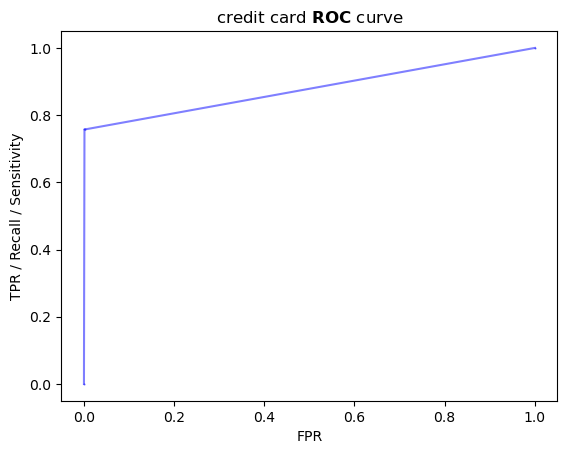

In [77]:
plt.plot(FPR, TPR, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR / Recall / Sensitivity")
plt.title(f"credit card $\\bf ROC$ curve")
plt.savefig("/tmp/ROC-curve.png", dpi=200)
plt.show()

FPR $\approx$ 1 for imbalanced data when we label all records as positive.<br>
Because of the imbalance, the FPR has from the beginning on very low values. For imbalanced data, th ROC AUC of this curve is not ideal to compare different algorithms:<br>
Suppose there are 100 positive cases in the data and 100'000 negative cases:<br>

\begin{eqnarray}
\text{algorithm 1: 2000 false positives:  FPR } =\frac{\text{FP}}{\text{FP + TN}} = &\frac{2000}{2000 + 100000} = 0.0196\\
\text{algorithm 2:   200  false positives:  FPR } =\frac{\text{FP}}{\text{FP + TN}} = &\;\;\frac{200}{200+ 100000} \;=\; 0.001966
\end{eqnarray}

The second algorithms has 10 times less false positives but only a very small range of the FPR scale indicates this.

(array([19998.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   101.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

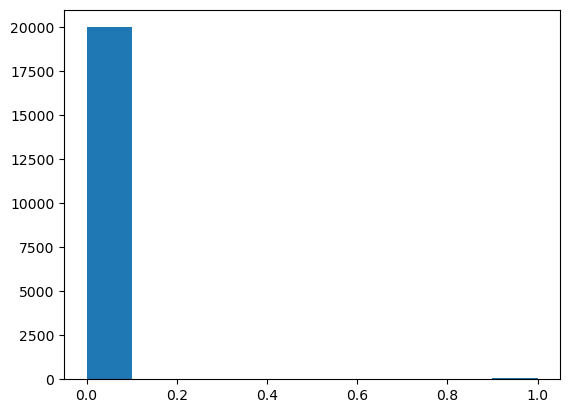

In [78]:
plt.hist(y_pred_proba)

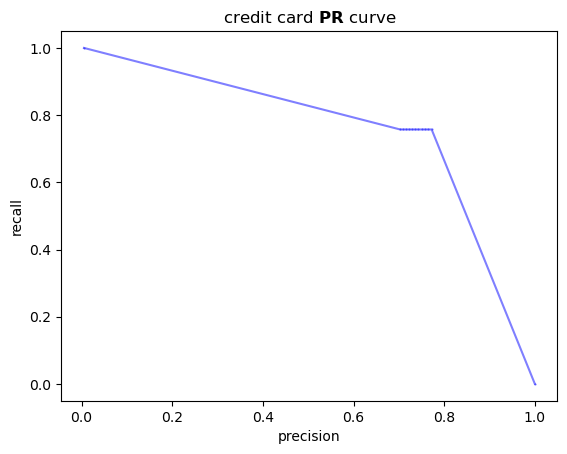

In [80]:
plt.plot(precision, recall, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("precision")
plt.ylabel("recall")
plt.title(f"credit card $\\bf PR$ curve")
plt.savefig("/tmp/PR-curve.png", dpi=200)
plt.show()

For imbalanced data, precision is the better measure:
Suppose there are 100 positive cases in the data and 100'000 negative cases:<br>
Both algorithms classifiy 50 cases correctly:<br>

\begin{eqnarray}
\text{algorithm 1: 2000 false positives:  }\; \text{Precision}=\frac{\text{TP}}{\text{TP + FP}} = &\frac{50}{50 + 2000} = 0.0243\\
\text{algorithm 2:   200  false positives:  }\; \text{Precision}=\frac{\text{TP}}{\text{TP + FP}} = &\;\;\frac{50}{50 + 200} \;=\; 0.2
\end{eqnarray}

For the discussion about the correct AUC-messure see: https://opendata.uni-halle.de/bitstream/1981185920/12388/1/1_3Fayzrakhmanov.pdf
or: https://www.biostat.wisc.edu/~page/rocpr.pdf

In [81]:
# keep the workspace tidy
y_pred, confusion, y_pred_proba, precision, recall = None, None, None, None, None
del y_pred, confusion, y_pred_proba, precision, recall

### Matthews Correlation Coefficient
[For a scientific discussion see here](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)<br>
\begin{equation}
\text{M} = \frac{\text{TP}\cdot\text{TN} - \text{FP}\cdot\text{FN}}{
\sqrt{(\text{TP} + \text{FP})\cdot(\text{TP} + \text{FN}) \cdot(\text{TN} + \text{FP}) \cdot(\text{TN} + \text{FN})}}
\end{equation}



## proper test set?
Since one class is underrepresented and there are very few instances of this class, a random split into train and test set could lead to even more accentuated imbalance in one of the sets. Evaluation of the performance of an algorithm would depend strongly on this random split.<br>
We try to distribute the minority class evenly across the test and train data.

In [82]:
# must split out test set first but get 20% from each class at original ratio of fraud/good
df_good = df[df['Class']==0]
df_fraud = df[df['Class']==1]

df_train_good, df_test_good   = train_test_split(df_good, test_size=0.20)
df_train_fraud, df_test_fraud = train_test_split(df_fraud, test_size=0.20)

df_train = pd.concat([df_train_good, df_train_fraud], axis=0)
df_test  = pd.concat([df_test_good, df_test_fraud], axis=0)

print(f"TRAIN num fraud {np.sum(df_train['Class']==1)}/{len(df_train)} = {100*np.sum(df_train['Class']==1)/len(df_train):.2f}%")
print(f"TEST num fraud {np.sum(df_test['Class']==1)}/{len(df_test)} = {100*np.sum(df_test['Class']==1)/len(df_test):.2f}%")

TRAIN num fraud 393/80393 = 0.49%
TEST num fraud 99/20099 = 0.49%


In [83]:
# keep the workspace tidy
df_good, df_fraud, df_train_good, df_test_good, df_train_fraud, df_test_fraud, df_train, df_test =None,None,None,None, None, None, None,None
del df_good, df_fraud, df_train_good, df_test_good, df_train_fraud, df_test_fraud, df_train, df_test

we can also do this with a sklearn data-set splitter:

In [84]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.2, train_size=0.8)
idx = next(splitter.split(df, df.Class))
train_idx = idx[0]
test_idx = idx[1]

In [85]:
len(test_idx)

20099

In [86]:
df_train = df.loc[train_idx]
df_test = df.loc[test_idx]
print(f"TRAIN num fraud {np.sum(df_train['Class']==1)}/{len(df_train)} = {100*np.sum(df_train['Class']==1)/len(df_train):.2f}%")
print(f"TEST num fraud {np.sum(df_test['Class']==1)}/{len(df_test)} = {100*np.sum(df_test['Class']==1)/len(df_test):.2f}%")

TRAIN num fraud 394/80393 = 0.49%
TEST num fraud 98/20099 = 0.49%


### Everything is in place to evaluate some strategies to cope with the imbalance:
 - correct metrics to focus on
 - even distribution of the minority class
 
 The base result - without applying any imbalance strategy - is the following:

In [87]:
X_train, y_train = df_train.drop('Class', axis=1), df_train['Class']
X_test, y_test = df_test.drop('Class', axis=1), df_test['Class']
clf = copy(model)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,F,T
F,19986,15
T,21,77


In [89]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")


Precision 0.837, Recall 0.786
F1 0.81, Accuracy 0.9982
ROC AUC 0.98, AUC PR 0.79
Matthews Corr-Coef: 0.8100352371837012


In [90]:
# keep workspace tidy
df, idx, df_train, df_test, clf, precision, recall, y_pred, y_pred_proba = None, None, None, None, None, None, None, None,None
del df, idx, df_train, df_test, clf, precision, recall, y_pred, y_pred_proba

# Strategies for the imbalanced case:
 - oversample the minority class
 - undersample the majority class
 - do both of the former two suggestions
 - oversample only the cases that get missclassified
 - set `is_unbalance` and/or `scale_pos_weight` parameters in lightgbm

## oversample fraud

### Synthetic Minority Oversampling Technique = SMOTE
The [original paper is here](https://arxiv.org/abs/1106.1813)<br>
The idea is to connect very close points in the feature space and generate new samples lying on the connecting line. This is done for the minority class only.

In [91]:
import imblearn
from imblearn.over_sampling import SMOTE, ADASYN
X_train_ov, y_train_ov = SMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)

In [92]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,F,T
F,19996,5
T,19,79


In [93]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")

Precision 0.940, Recall 0.806
F1 0.87, Accuracy 0.9988
ROC AUC 0.98, AUC PR 0.87
Matthews Corr-Coef: 0.8701372635951283


In [94]:
X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf = None, None, None, None, None, None, None
del X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf

### Adaptive Synthetic Sampling = ADASYN
The [paper can be found here](https://www.ele.uri.edu/faculty/he/PDFfiles/adasyn.pdf).<br>
More synthetic observations are generated in areas where the density of the minority class is very low. Those cases are hard to learn and upsampling them with SMOTE should make it easier to learn.

In [95]:
# needs too much RAM: 
X_train_ov, y_train_ov = ADASYN(sampling_strategy=0.05).fit_resample(X_train, y_train)

In [96]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,F,T
F,19998,3
T,19,79


In [97]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")

Precision 0.963, Recall 0.806
F1 0.88, Accuracy 0.9989
ROC AUC 0.98, AUC PR 0.87
Matthews Corr-Coef: 0.8807500415710048


In [99]:
X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf = None, None, None, None, None, None, None
del X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf

### Borderline-SMOTE
The [paper can be found here](https://sci2s.ugr.es/keel/keel-dataset/pdfs/2005-Han-LNCS.pdf)<br>
The principal idea is to upsample only those observations that are not classified correctly. The missclassified instances are found by k-nearest-neighbors.

In [100]:
# needs to much RAM for me:
from imblearn.over_sampling import BorderlineSMOTE
X_train_ov, y_train_ov = BorderlineSMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)

In [101]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,F,T
F,19996,5
T,18,80


In [102]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")

Precision 0.941, Recall 0.816
F1 0.87, Accuracy 0.9989
ROC AUC 0.98, AUC PR 0.88
Matthews Corr-Coef: 0.8759783590108982


In [103]:
X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf = None, None, None, None, None, None, None
del X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf

### Support-Vector-Machine-SMOTE = SVMSMOTE
The class-boundaries for the Borderline are learned as the support-vectors of a Support-Vector-Machine.

In [104]:
from imblearn.over_sampling import SVMSMOTE
X_train_ov, y_train_ov = SVMSMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)

In [105]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,F,T
F,19996,5
T,19,79


In [106]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")

Precision 0.940, Recall 0.806
F1 0.87, Accuracy 0.9988
ROC 0.98, AUC PR 0.87
Matthews Corr-Coef: 0.8701372635951283


In [107]:
# keep the workspace tidy
X_train_ov, y_train_ovm, y_pred, clf = None, None, None, None
del X_train_ov, y_train_ovm, y_pred, clf

## weigh minority class

### 1. is_unbalace = True

In [108]:
clf = copy(model)
clf.set_params(is_unbalance = True)
#, scale_pos_weight

LGBMClassifier(is_unbalance=True, n_estimators=500, objective='binary',
               scale_pos_weight=1.0, silent=True, subsample_for_bin=20000)

In [109]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,F,T
F,16020,3981
T,11,87


In [110]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")

Precision 0.021, Recall 0.888
F1 0.04, Accuracy 0.8014
ROC 0.85, AUC PR 0.45
Matthews Corr-Coef: 0.11940092452248828


### 2. scale the minority instances with higher weights during fitting

In [111]:
clf.set_params(is_unbalance=False, scale_pos_weight=200.0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,F,T
F,17047,2954
T,23,75


In [112]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")

Precision 0.025, Recall 0.765
F1 0.05, Accuracy 0.8519
ROC 0.81, AUC PR 0.40
Matthews Corr-Coef: 0.1202511617802641


In [113]:
# house-keeping
y_pred_proba, precision, recall, clf, y_pred = None, None, None, None, None
del y_pred_proba, precision, recall, clf, y_pred

## Undersample Fraud

In [114]:
from imblearn.under_sampling import RandomUnderSampler
X_train_u, y_train_u = RandomUnderSampler(sampling_strategy=0.5).fit_resample(X_train, y_train)
print(X_train.shape, X_train_u.shape)

(80393, 31) (1182, 31)


In [115]:
clf = copy(model)
clf.fit(X_train_u,y_train_u)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,F,T
F,19596,405
T,10,88


In [116]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")

Precision 0.178, Recall 0.898
F1 0.30, Accuracy 0.9794
ROC 0.98, AUC PR 0.86
Matthews Corr-Coef: 0.3952501809663221


In [117]:
y_pred_proba, y_pred, precision, recall, clf, X_train_u, y_train_u = None, None, None, None, None, None, None
y_pred_proba, y_pred, precision, recall, clf, X_train_u, y_train_u

(None, None, None, None, None, None, None)

## do both: oversample minority class and undersample majority class

### SMOTE and Edited Nearest Neighbors = SMOTE-ENN
  - SMOTE is used for upsampling
  - ENN removes an observation and its (k=3) nearest neighbors when the majority class of the nearest neighbors is different from the observation's class
  
### SMOTETOMEK
  - this method finds reciprocal nearest-neighbors that are in different classes; These pairs are called Tomek-Links
  - the observation in such a pair, belonging to the majority class is deleted

In [118]:
# not enough RAM
from imblearn.combine import SMOTEENN
X_train_uo, y_train_uo = SMOTEENN().fit_resample(X_train, y_train)
# X_train_uo, y_train_uo = SMOTETomek(random_state=0).fit_resample(X_train, y_train)
# print(X_train.shape, X_train_uo.shape)

## get best combination: sampling and hyper-parameters

In [119]:
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import BorderlineSMOTE
clf = copy(model)
clf.set_params(num_leaves=64)
borderline = BorderlineSMOTE(random_state=88)
grid = {'class__n_estimators': [200, 500],
        'class__neg_bagging_fraction': [0.1, 0.3],
        'class__max_depth' : [4, 6, 8,],
        'class__learning_rate' :[0.05, 0.1],
        'sampling__sampling_strategy' :[0.1, 0.3]}
pipeline = Pipeline([('sampling', borderline), ('class', clf)])
grid_cv = GridSearchCV(pipeline, grid, scoring = 'f1', cv = 5, refit=True)
   
grid_cv.fit(X_train, y_train)
display(grid_cv.best_score_, grid_cv.best_params_)

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and w

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


0.8934255838689337

{'class__learning_rate': 0.1,
 'class__max_depth': 8,
 'class__n_estimators': 500,
 'class__neg_bagging_fraction': 0.1,
 'sampling__sampling_strategy': 0.3}

In [120]:
pipeline.set_params(**grid_cv.best_params_)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)#[:, 1]

confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,F,T
F,19994,7
T,17,81


In [121]:
y_pred_proba = pipeline.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")

Precision 0.920, Recall 0.827
F1 0.87, Accuracy 0.9988
ROC 0.99, AUC PR 0.87
Matthews Corr-Coef: 0.8716420414976734


## One-Class SVM
Train on majority class only and classifiy test-set in in-class examples and out-class examples:

In [ ]:
from sklearn.svm import OneClassSVM 

train_normal = X_train[y_train == 0] 
train_outliers = X_train[y_train == 1]

In [ ]:
outlier_prop = len(train_outliers) / len(train_normal) 
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.000001) 
svm.fit(train_normal)

In [ ]:
y_pred = svm.predict(X_test)
y_pred_corrected = np.zeros_like(y_pred)
y_pred_corrected[y_pred == -1] = 1

In [ ]:
y_test


In [ ]:
confusion = confusion_matrix(y_test, y_pred_corrected)

df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

In [ ]:
AUC = roc_auc_score(y_test, y_pred_corrected)
precision, recall, _ = precision_recall_curve(y_test, y_pred_corrected, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred_corrected):.3f}, Recall {recall_score(y_test, y_pred_corrected):.3f}")
print(f"F1 {f1_score(y_test, y_pred_corrected):.2f}, Accuracy {accuracy_score(y_test, y_pred_corrected):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")
print(f"Matthews Corr-Coef: {matthews_corrcoef(y_test, y_pred_proba>0.5)}")

Pros:
  - It works really well with a clear margin of separation
  - It is effective in high dimensional spaces.
  - It is effective in cases where the number of dimensions is greater than the number of samples.
  - It uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

Cons:
  - It doesn’t perform well when we have large data set because the required training time is higher
  - It also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping
  - SVM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. It is included in the related SVC method of Python scikit-learn library.